In [1]:
"""
이미지 분할 또는 세그멘테이션은 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는것

즉 모든 픽셀은 어떤 클래스에 속한다 
- 예를 들어 배경 클래스와 객체 클래스로 구성된 이미지가 있다면 
- 모든 픽셀은 배경 또는 객체 중 하나로 분류된다
- 이렇게 모든 픽셀에 대한 정답 클래스를 레이블 처리한 데이터셋을 가지고,
- 딥러닝 모델을 훈련 시키면 정답 클래스를 알지 못하는 새로운 이미지에 대해서 배경과 객체를 분리할 수 있다

- 이미지 분할은 의미 분할과 인스턴스 분할로 구분된다
-의미 분할은 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분하지만, (예 사람들의 모습 이미지를 사람들 인식)
-인스턴스 분할은 같은 범주에 속하더라도 서로 다른 객체를 구분하는 개념이다 (예 사람들의 모습 이미지에서 각각 사람을 따로 인식)
"""

'\n이미지 분할 또는 세그멘테이션은 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는것\n\n즉 모든 픽셀은 어떤 클래스에 속한다 \n- 예를 들어 배경 클래스와 객체 클래스로 구성된 이미지가 있다면 \n- 모든 픽셀은 배경 또는 객체 중 하나로 분류된다\n- 이렇게 모든 픽셀에 대한 정답 클래스를 레이블 처리한 데이터셋을 가지고,\n- 딥러닝 모델을 훈련 시키면 정답 클래스를 알지 못하는 새로운 이미지에 대해서 배경과 객체를 분리할 수 있다\n\n- 이미지 분할은 의미 분할과 인스턴스 분할로 구분된다\n-의미 분할은 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분하지만, (예 사람들의 모습 이미지를 사람들 인식)\n-인스턴스 분할은 같은 범주에 속하더라도 서로 다른 객체를 구분하는 개념이다 (예 사람들의 모습 이미지에서 각각 사람을 따로 인식)\n'

In [1]:
"""
# 데이터셋 준비

이미지 분할 예제에 사용할 데이터셋은 Oxford-IIIT Pet Dataset이다

이 데이터셋은 반려동물의 이미지 및 분류 레이블, 각 이미지를 구성하는 픽셀 단위의 마스크로 구성되어있다
여기서 말하는 마스크는 각 픽셀에 대한 범주 레이블을 나타낸다.
각 픽셀은 다음 세 가지 범주 중 하나에 속한다

class 1 : 반려동물이 속한 픽셀
class 2 : 반려동물과 인접한 픽셀
class 3 : 위에 속하지 않는경우/ 주변 픽셀
"""
#필수 라이브러리
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds

In [2]:
# 이미지 크기 
img_w = 128
img_h =128
img_c = 3
img_shape = (img_w, img_h, img_c)

#모델 학습
epoch_num =5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

In [3]:
#텐서플로 데이터셋 로드
ds_str = "oxford_iiit_pet"
ds, info = tfds.load(name=ds_str, with_info = True)

In [4]:
"""
원본 이미지와 분할 마스크를 전처리하는 함수를 정의한다. 이미지 크기를 사전에 정의한(128, 128) 크기로 변경하고 자료형을 변환한다
원본 이미지의 픽셀을 255로 나눠서 0~1 범위로 정규화
마스크는 0,1,2의 정수형 값을 갖도록 1을 차감
"""
# 이미지 전처리 함수 
def preprocess_image(ds):
    # 원본 이미지
    img = tf.image.resize(ds['image'], (img_w, img_h))
    img = tf.cast(img, tf.float32) / 255.0
    # 분할 마스크 
    mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1
    return img, mask

In [5]:
# 데이터 전처리 파이프라인
train_ds = ds["train"].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds["test"].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

In [6]:
"""
샘플 배치를 한개 선택
배치에는 16개의 샘플 이미지와 마스크 이미지가 들어 있다
"""
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

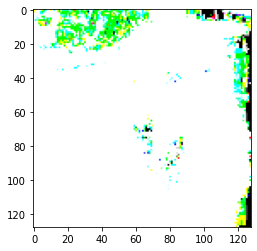

In [7]:
"""
배치에서 첫 번째 이미지를 출력 
0~1 사이의 값이므로 255를 곱해서 정규화 이전의 원래 값으로 복원
"""
# 샘플 이미지 출력
img_255 = np.array(img[0])*255.0
img_255 = cv2.cvtColor(img_255, cv2.COLOR_RGB2BGR)
plt.imshow(img_255)
plt.show()


In [8]:
"""
U-Nnet 모델 (인코더-디코더)

사전 학습된 VGG16 모델을 인코더로 활용하는 U-Net 모델을 만들어 본다
VGG16 은 이미지넷 경진 대회를 통해 성능이 검증된 모델이다 
사실 사전 학습된 모델 없이 U-Net을 구성하여 학습을 진행해도 학습은 된다 -
단 데이터 개수가 충분하고, 시간이 충분하는 전제에서 말이다

- 먼저 VGG16 모델을 최종 레이어를 제외한 채로 불러온다
"""
# VGG16 모델
base_model = tf.keras.applications.VGG16(input_shape = img_shape, include_top = False)

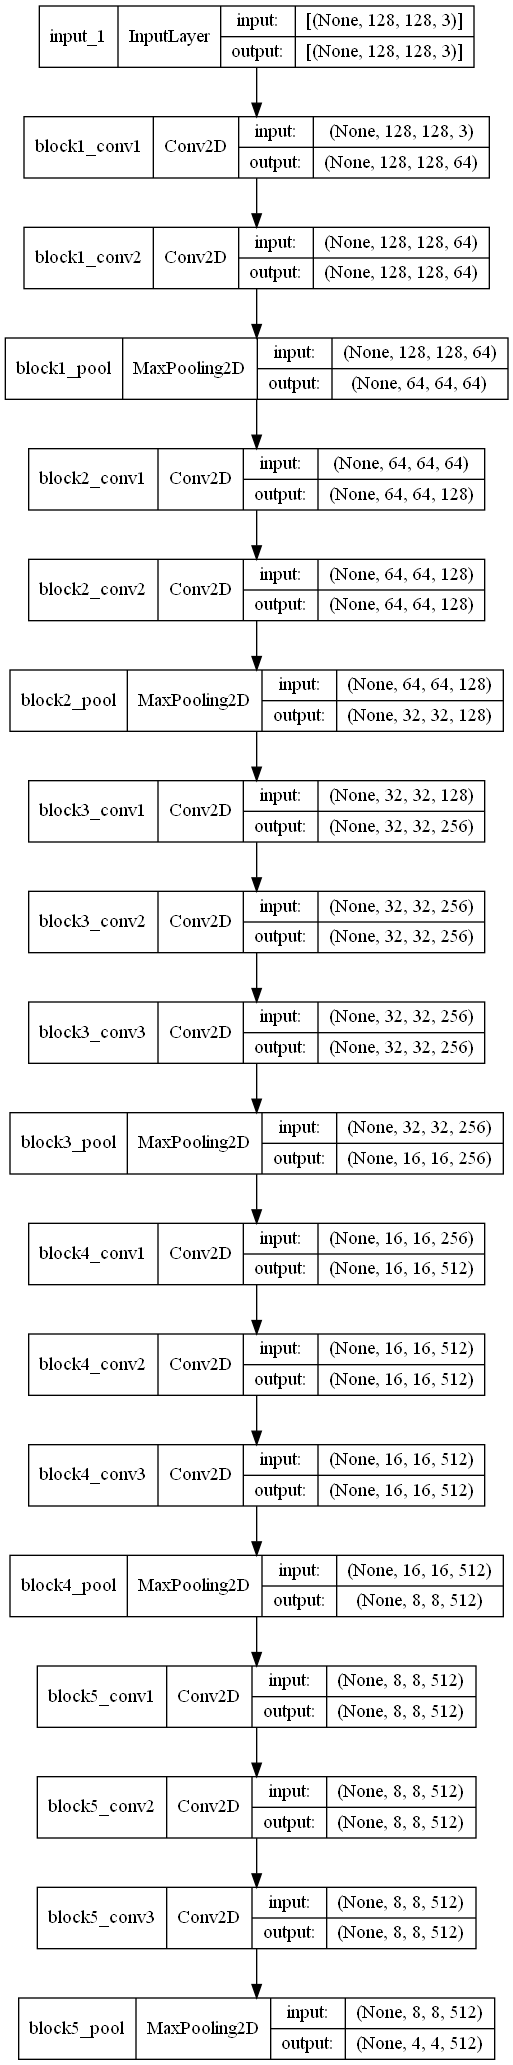

In [10]:
"""
VGG!6 모델은 합성곱 층과 풀링 층을 직렬로 연결한 구조를 갖는다 
모델 구조를 모변 (128, 128) 크기의 텐서가 마지막 레이어에서는 (4, 4)크기로 축소 된것을 
확인 할 수 있다

마스크 정답을 활용하여 각 픽셀의 마스크 범주를 0, 1, 2 중에서 하나로 분류하는 역할
"""
#모델 구조 
tf.keras.utils.plot_model(base_model, show_shapes=True)

In [11]:
"""
여기서는 VGG16 모델로 부터 5개의 출력을 가져와서 사용한다 
다음과 같이 새로운 Feature Extractor 모델을 정의하고, f_model 변수에 저장한다
1개의 입력과 5개의 출력을 갖는다
"""
# VGG16 중간 레이어 출력 텐서를 지정
f_model = tf.keras.Model(inputs=[base_model.input], outputs =[ base_model.get_layer(name='block5_conv3').output,
                                base_model.get_layer(name='block4_conv3').output,
                                base_model.get_layer(name='block3_conv3').output,
                                base_model.get_layer(name='block2_conv2').output,
                                base_model.get_layer(name='block1_conv2').output
                                                             ])

In [12]:
"""
사전 학습된 파라미터를 인코더에 그대로 사용하기 위해서 업데이트되지 않도록 고정
"""
# 파라미터 고정
f_model.trainable = False

In [13]:
"""
인코더 부분에서 5개의 출력을 가져와서 디코더의 입력으로 전달하면서 
업샘플링(Up Sampling) 한다
업샘플링은 축소된 이미지를 원래 이미지 크기로 복원하는 과정을 말한다
제일 작은 (8, 8, 512) 텐서에서 시작해서 조금씩 크기를 키워 나가며 중간 출력과 합친다
"""
# U-Net 구조로 모델 정의
i=tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out,out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same') (out)
out = tf.keras.layers.Dense(3,activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

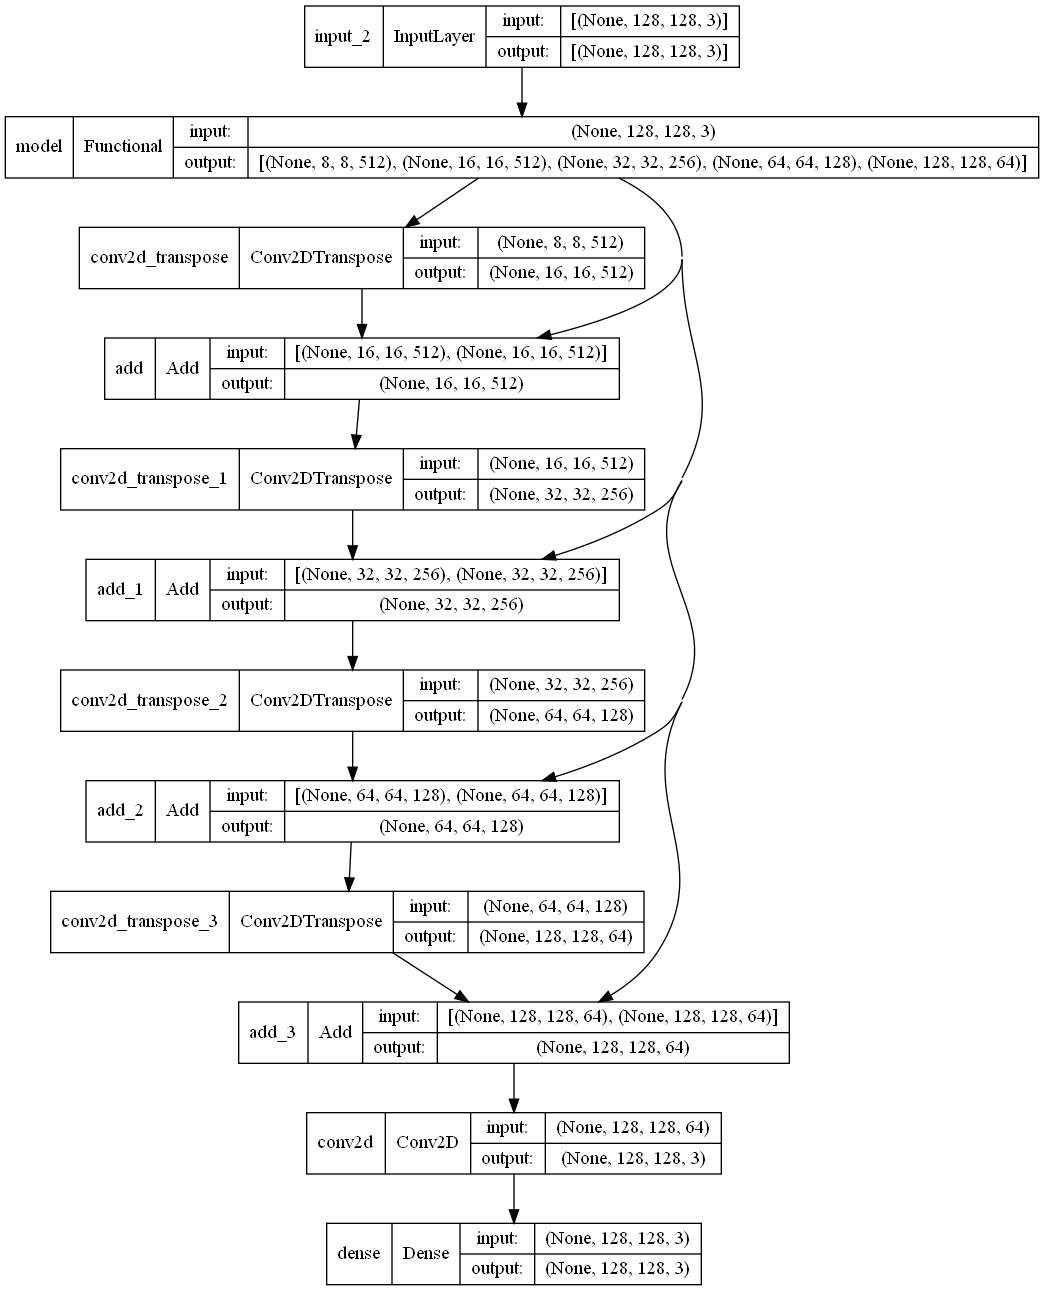

In [14]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model,show_shapes=True)

In [15]:
#모델 요약 
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 8, 8, 512),  14714688    ['input_2[0][0]']                
                                 (None, 16, 16, 512                                               
                                ),                                                                
                                 (None, 32, 32, 256                                               
                                ),                                                          

In [16]:
"""
예측 클래스 개수가 3개인 다중 분류 문제에 맞ㄷ록 SparseCategoricalCrossentropy 손실함수를 설정하고,
Adam 옵티마이저를 적용한다 
기본 성능을 확인하는 수준에서 5 epcoh만 훈련한다
"""
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=["accuracy"])
unet_model.fit(train_ds, batch_size=batch_size, epochs=10)

Epoch 1/10
230/230 [==============================] - 17s 36ms/step - loss: 0.9051 - accuracy: 0.7080
Epoch 2/10
230/230 [==============================] - 9s 36ms/step - loss: 0.5965 - accuracy: 0.8037
Epoch 3/10
230/230 [==============================] - 9s 37ms/step - loss: 0.5661 - accuracy: 0.8154
Epoch 4/10
230/230 [==============================] - 9s 37ms/step - loss: 0.5481 - accuracy: 0.8210
Epoch 5/10
230/230 [==============================] - 9s 37ms/step - loss: 0.5328 - accuracy: 0.8253
Epoch 6/10
230/230 [==============================] - 9s 39ms/step - loss: 0.5200 - accuracy: 0.8280
Epoch 7/10
230/230 [==============================] - 9s 38ms/step - loss: 0.5077 - accuracy: 0.8310
Epoch 8/10
230/230 [==============================] - 10s 41ms/step - loss: 0.4932 - accuracy: 0.8349
Epoch 9/10
230/230 [==============================] - 9s 38ms/step - loss: 0.4814 - accuracy: 0.8380
Epoch 10/10
230/230 [==============================] - 9s 39ms/step - loss: 0.4673 - accu

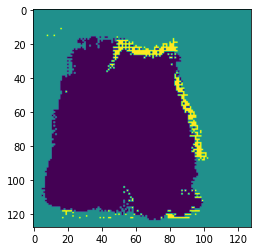

In [23]:
"""
검증 셋의 배치를 하나 선택하고 predict() 메소드로 이미지 분할 클래스를 예측한다
배치를 구성하는 16개 이미지 중에서 첫 번째 이미지의 분할 결과를 노트북에 출력
"""


# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫번째 이미지 분할 결과를 출력
pred_img=np.argmax(pred[0], -1)
plt.imshow(pred_img)



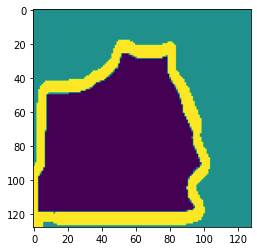

In [24]:


# 첫번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0], (128,128)))

